# Material Style of Life Principal Component Analysis

In [577]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from zipfile import ZipFile
import seaborn as sns
import os
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from factor_analyzer import FactorAnalyzer


pd.options.mode.chained_assignment = None 
plt.style.use("seaborn-darkgrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

/tmp/ipykernel_4749/130353575.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


In [578]:
df_raw = pd.read_csv('/home/rthoms/ocean_dep/sur_C/adaptive_cap_clean.csv')

In [579]:
# drop duplicates from the cleaned table (if multiple gears were recorded, each has an entry)
df_raw= df_raw.drop_duplicates(subset=['id'], keep='first')

In [580]:
df_raw.columns

Index(['Unnamed: 0', 'id', 'date', 'ccp', 'gender', 'age', 'birth_place',
       'mar_status', 'ed_level', 'house_head', 'glean', 'electricity',
       'fridge_freezer', 'fridge_freezer_num', 'water', 'matress',
       'matress_num', 'mobile_phone', 'mobile_phone_num', 'smart_phone',
       'smart_phone_num', 'fan', 'fan_num', 'tv', 'tv_num', 'radio',
       'radio_num', 'stove', 'stove_num', 'transport', 'transport_num',
       'floor', 'floor_other', 'wall', 'wall_other', 'roof', 'roof_other',
       'access_credit_loans', 'community_participation', 'ccp_member',
       'ccp_participation', 'decision_making_manag', 'decision_making_fish',
       'change_seagrass', 'direction_change_seagrass',
       'causes_change_seagrass', 'change_fish', 'direction_change_resources',
       'causes_change_resources', 'link_seagrass_resources',
       'capacity_change_practice', 'capacity_change_livelihood',
       'capacity_organize', 'local_knowledge', 'agency_change_seagrass',
       'agency_chan

In [581]:
# subset the data frame columns to the MSL questions only
df= df_raw[['id', 'pract_cat', 'electricity',
    'fridge_freezer', 'fridge_freezer_num', 'water', 'matress',
    'matress_num', 'mobile_phone', 'mobile_phone_num', 'smart_phone',
    'smart_phone_num', 'fan', 'fan_num', 'tv', 'tv_num', 'radio',
    'radio_num', 'stove', 'stove_num', 'transport', 'transport_num',
    'floor', 'floor_other', 'wall', 'wall_other', 'roof', 'roof_other']].copy()

## Data transformation
Some of the MSL questions if the respondent possess an asset, they are then asked how many of that asset they have. <br>
These two columns will be combined into one column with the number of assets of that type.

In [582]:
# function to combine the Yes/No and Number columns
# Any values that were not recorded will be replaced with 0s
def fill_NR(boolean, num):
    if boolean == 'NR':
        return 0
    else:
        return boolean

In [583]:
# function to pull item from dict
def set_scale(dic,indicator):
    scale=dic[indicator]
    return scale

In [584]:
# combine the boolean and number columns for the applicable questions
df['fridge_freezer']= df.apply(lambda row: fill_NR(row['fridge_freezer'], row['fridge_freezer_num']), axis=1 )
df['matress']= df.apply(lambda row: fill_NR(row['matress'], row['matress_num']), axis=1 )
df['mobile_phone']= df.apply(lambda row: fill_NR(row['mobile_phone'], row['mobile_phone_num']), axis=1 )
df['smart_phone']= df.apply(lambda row: fill_NR(row['smart_phone'], row['smart_phone_num']), axis=1 )
df['fan']= df.apply(lambda row: fill_NR(row['fan'], row['fan_num']), axis=1 )
df['tv']= df.apply(lambda row: fill_NR(row['tv'], row['tv_num']), axis=1 )
df['radio']= df.apply(lambda row: fill_NR(row['radio'], row['radio_num']), axis=1 )
df['stove']= df.apply(lambda row: fill_NR(row['stove'], row['stove_num']), axis=1 )

There are no respondents with more than one tranportation

In [585]:
print(df['transport_num'].unique())

[nan]


The questions about transportation, floors, walls, and roofs list several options. These options will each represent an asset, and must therefore be transformed into columns. Before this transformation can be made, it will be necessary to adress the values stored in the 'other' column

In [586]:
# examine any rows where the repsonse for floor type is other
other = df[df['floor'] == 'other']
other[['id', 'floor','floor_other']]

,id,floor,floor_other
58,03032023MADC08,other,Nao registado


In [587]:
# Reclassify responses
df.loc[df['id'] == '03032023MADC08', 'floor'] = None

In [588]:
# examine any rows where the repsonse for wall type is other
other = df[df['wall'] == 'other']
other[['id', 'wall','wall_other']]

,id,wall,wall_other
2,05032023JOSC03,other,Macuti
20,09032023NHCHC05,other,Macuti
23,09032023NHCHC08,other,Macuti
36,01032023MARC05,other,Macuti
54,03032023MADC04,other,Macuti
57,03032023MADC07,other,Macuti
58,03032023MADC08,other,nao registado
65,11032023KUGC06,other,Macuti


In [589]:
# Reclassify responses
# Macuti is braided palm fronds - this is in the same categorty as thatched reeds
macuti = list(other[other['id']!='03032023MADC08']['id'])
df.loc[df['id'].isin(macuti), 'wall'] = 'reeds'
df.loc[df['id'] == '03032023MADC08', 'reeds'] = None

In [590]:
# examine any rows where the repsonse for roof type is other
other = df[df['roof'] == 'other']
other[['id', 'roof','roof_other']]

,id,roof,roof_other
58,03032023MADC08,other,nao registado
79,08032023MORC04,other,Macuti
82,08032023MORC07,other,Macuti


In [591]:
# Reclassify responses
macuti = list(other[other['id']!='03032023MADC08']['id'])
# Macuti is braided palm fronds - this is in the same categorty as thatched straw
df.loc[df['id'].isin(macuti), 'roof'] = 'straw'
df.loc[df['id'] == '03032023MADC08', 'roof'] = None

In [592]:
def new_col_val(old_col_val, val):
    if old_col_val == val:
        return 1
    else:
        return 0
    
def make_new_cols(col):
    
    for val in df[col].unique():
        if val:
            col_nam = col + "_" + val
            df[col_nam]= df.apply(lambda row: new_col_val(row[col], val), axis=1 )

make_new_cols('transport')
make_new_cols('floor')
make_new_cols('wall')
make_new_cols('roof')

df.head()

,id,pract_cat,electricity,fridge_freezer,fridge_freezer_num,water,matress,matress_num,mobile_phone,mobile_phone_num,...,floor_sand,floor_tile,wall_metal,wall_reeds,wall_ciment,wall_wood,wall_brick,roof_metal,roof_straw,roof_tile
0,05032023JOSC01,glean,1,0,NaN,0,1,1.0,1,1.0,...,0,0,1,0,0,0,0,1,0,0
1,05032023JOSC02,glean,0,0,NaN,0,1,1.0,1,1.0,...,0,0,0,1,0,0,0,0,1,0
2,05032023JOSC03,fish,1,0,NaN,0,0,NaN,1,1.0,...,0,0,0,1,0,0,0,0,1,0
3,05032023JOSC04,glean,0,0,NaN,0,0,NaN,0,NaN,...,0,0,0,1,0,0,0,0,1,0
4,05032023JOSC05,shrimp_net,1,0,NaN,0,1,2.0,0,NaN,...,0,0,0,1,0,0,0,1,0,0


In [593]:
df.columns

Index(['id', 'pract_cat', 'electricity', 'fridge_freezer',
       'fridge_freezer_num', 'water', 'matress', 'matress_num', 'mobile_phone',
       'mobile_phone_num', 'smart_phone', 'smart_phone_num', 'fan', 'fan_num',
       'tv', 'tv_num', 'radio', 'radio_num', 'stove', 'stove_num', 'transport',
       'transport_num', 'floor', 'floor_other', 'wall', 'wall_other', 'roof',
       'roof_other', 'reeds', 'transport_no_transport', 'transport_bicycle',
       'transport_car', 'floor_concrete', 'floor_sand', 'floor_tile',
       'wall_metal', 'wall_reeds', 'wall_ciment', 'wall_wood', 'wall_brick',
       'roof_metal', 'roof_straw', 'roof_tile'],
      dtype='object')

In [594]:
df_transformed = df[['id', 'pract_cat',
                    'electricity', 
                    'fridge_freezer',
                    'water', 
                    'matress', 
                    'mobile_phone',
                    'smart_phone',
                    'fan',
                    'tv', 
                    'radio', 
                    'stove',
                    'transport_bicycle',
                    'transport_car', 
                    'floor_concrete', 
                    'floor_sand',
                    'floor_tile', 
                    'wall_metal', 
                    'wall_reeds', 
                    'wall_ciment', 
                    'wall_wood',
                    'wall_brick', 
                    'roof_metal', 
                    'roof_straw', 
                    'roof_tile']]

In [595]:
# make sure there are no NaN values
df_transformed[df_transformed.isna().any(axis=1)]

,id,pract_cat,electricity,fridge_freezer,water,matress,mobile_phone,smart_phone,fan,tv,...,floor_sand,floor_tile,wall_metal,wall_reeds,wall_ciment,wall_wood,wall_brick,roof_metal,roof_straw,roof_tile


In [596]:
# There are three entries with an NaN value. After reviewing the physical data sheet, this value should be 1
df_transformed.loc[df_transformed['id'] == '08032023MORC03', 'stove'] = 1
df_transformed.loc[df_transformed['id'] == '09032023NHCHC07', 'fridge_freezer'] = 1
df_transformed.loc[df_transformed['id'] == '08032023MORC02', 'fridge_freezer'] = 1

In [597]:
df_transformed.set_index('id', inplace=True)

## Data exploration

In [598]:
df_transformed.shape

(96, 24)

In [599]:
df_transformed.head()

,pract_cat,electricity,fridge_freezer,water,matress,mobile_phone,smart_phone,fan,tv,radio,...,floor_sand,floor_tile,wall_metal,wall_reeds,wall_ciment,wall_wood,wall_brick,roof_metal,roof_straw,roof_tile
id,,,,,,,,,,,,,,,,,,,,,
05032023JOSC01,glean,1,0,0,1,1,0,0,1,1,...,0,0,1,0,0,0,0,1,0,0
05032023JOSC02,glean,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
05032023JOSC03,fish,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
05032023JOSC04,glean,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
05032023JOSC05,shrimp_net,1,0,0,1,0,0,1,1,0,...,0,0,0,1,0,0,0,1,0,0


In [600]:
df_transformed.tail()

,pract_cat,electricity,fridge_freezer,water,matress,mobile_phone,smart_phone,fan,tv,radio,...,floor_sand,floor_tile,wall_metal,wall_reeds,wall_ciment,wall_wood,wall_brick,roof_metal,roof_straw,roof_tile
id,,,,,,,,,,,,,,,,,,,,,
19022023ILHC03,shrimp_net,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
19022023ILHC04,shrimp_net,1,0,0,1,1,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
19022023ILHc06,shrimp_net,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
19022023ILHC05,glean,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
19022023ILHC07,fish,1,1,0,0,1,1,0,1,0,...,0,0,0,0,1,0,0,1,0,0


In [601]:
df_transformed[["mobile_phone", "smart_phone", "fan","tv","radio"]] = df_transformed[["mobile_phone", "smart_phone", "fan","tv","radio"]].apply(pd.to_numeric)
df_transformed.dtypes

pract_cat            object
electricity           int64
fridge_freezer        int64
water                 int64
matress               int64
mobile_phone          int64
smart_phone           int64
fan                   int64
tv                    int64
radio                 int64
stove                 int64
transport_bicycle     int64
transport_car         int64
floor_concrete        int64
floor_sand            int64
floor_tile            int64
wall_metal            int64
wall_reeds            int64
wall_ciment           int64
wall_wood             int64
wall_brick            int64
roof_metal            int64
roof_straw            int64
roof_tile             int64
dtype: object

In [602]:
grouped = df_transformed.groupby(['pract_cat']).sum().reset_index()
grouped

,pract_cat,electricity,fridge_freezer,water,matress,mobile_phone,smart_phone,fan,tv,radio,...,floor_sand,floor_tile,wall_metal,wall_reeds,wall_ciment,wall_wood,wall_brick,roof_metal,roof_straw,roof_tile
0,fish,22,15,11,41,32,20,3,24,25,...,3,1,11,21,10,0,5,38,8,1
1,glean,11,3,6,17,14,4,2,9,5,...,1,0,6,14,2,0,2,17,6,1
2,shrimp_net,12,4,5,20,15,5,3,7,9,...,4,0,7,11,3,1,2,19,5,0


In [603]:

num_cols = [col for col in df_transformed.columns if df_transformed[col].dtype in ['int64','float64']]

# variance among numerircal features
var= df_transformed[num_cols].var()

# create DataFrame from variance values
var_df = pd.DataFrame({'Variance': var})

# print Variance DataFrame
var_df


,Variance
electricity,0.251645
fridge_freezer,0.178509
water,0.178509
matress,0.153947
mobile_phone,0.234101
smart_phone,0.213048
fan,0.077193
tv,0.245614
radio,0.243750
stove,0.068311


In [604]:
# calculate coefficient of variation (CV)
cv = (df_transformed[num_cols].std() / df_transformed[num_cols].mean())*100

# create DataFrame from CV values
cv_df = pd.DataFrame({'CV': cv})

# print CV DataFrame
cv_df

,CV
electricity,107.016969
fridge_freezer,184.364939
water,184.364939
matress,48.290618
mobile_phone,76.145268
smart_phone,152.796081
fan,333.403501
tv,118.942711
radio,121.528724
stove,358.442747


The data needs to be normalized, as there is a high degree of heterogeneity among features (CV > 35%).

## Principal Component Analysis
### Standardize data
Data must be standardized since PCA's output is influenced based on the sclae of the features of the data. Import the `StandardScaler` module from sklearn and apply scaling by doing a fit transform. Each feature of the data will be normall distributed such that it will scale the distribution to a mean of zero and a standard deviation of one

In [605]:
# define features for factor analysis - this is all the MSL colums. We just need to remove the 'pract_cat' column
features = list(df_transformed.columns)
features.remove('pract_cat')

# normalizing features
X = df_transformed.loc[:, features].values
X_norm = StandardScaler().fit_transform(X) # normalizing the features

# principal component analysis on features
pca = PCA()

X_pca = pca.fit_transform(X_norm)

# converting to dataframe
names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pcadf = pd.DataFrame(X_pca, columns=names)


print(X_pcadf.head())
print("-----------------------------------")
print("Shape of PCA DataFrame:", X_pcadf.shape)


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.559720 -0.242553 -1.033298 -0.600721 -1.058472 -0.276300  0.767450   
1  2.713550 -0.403387 -0.516661 -0.079013  0.878983  0.081917 -0.370805   
2  2.785123  0.352852 -0.772555  0.867834  0.938868  0.168799 -1.987541   
3  3.090845 -0.434662  0.948113  2.036168  0.110904  0.719936 -1.164772   
4 -0.361597  0.299489 -0.916720  1.679936 -0.482884  1.038604  0.625666   

        PC8       PC9      PC10  ...      PC14      PC15      PC16      PC17  \
0 -0.437657  0.318966 -0.749643  ... -1.070278 -0.420142 -0.561571  0.517622   
1  0.256896  0.283613 -0.100769  ... -0.154274 -0.759134  0.888094 -0.915350   
2 -0.105587  0.475458 -0.320398  ... -0.617319 -1.170414 -0.417792  0.230311   
3 -0.468120  0.113858  0.121181  ...  0.259236 -0.976942 -0.480847 -0.689136   
4  1.734033  2.022624  0.121632  ...  1.355649  1.661918  0.214137  0.182248   

       PC18      PC19      PC20      PC21          PC22          PC2

### Correlation Matrix

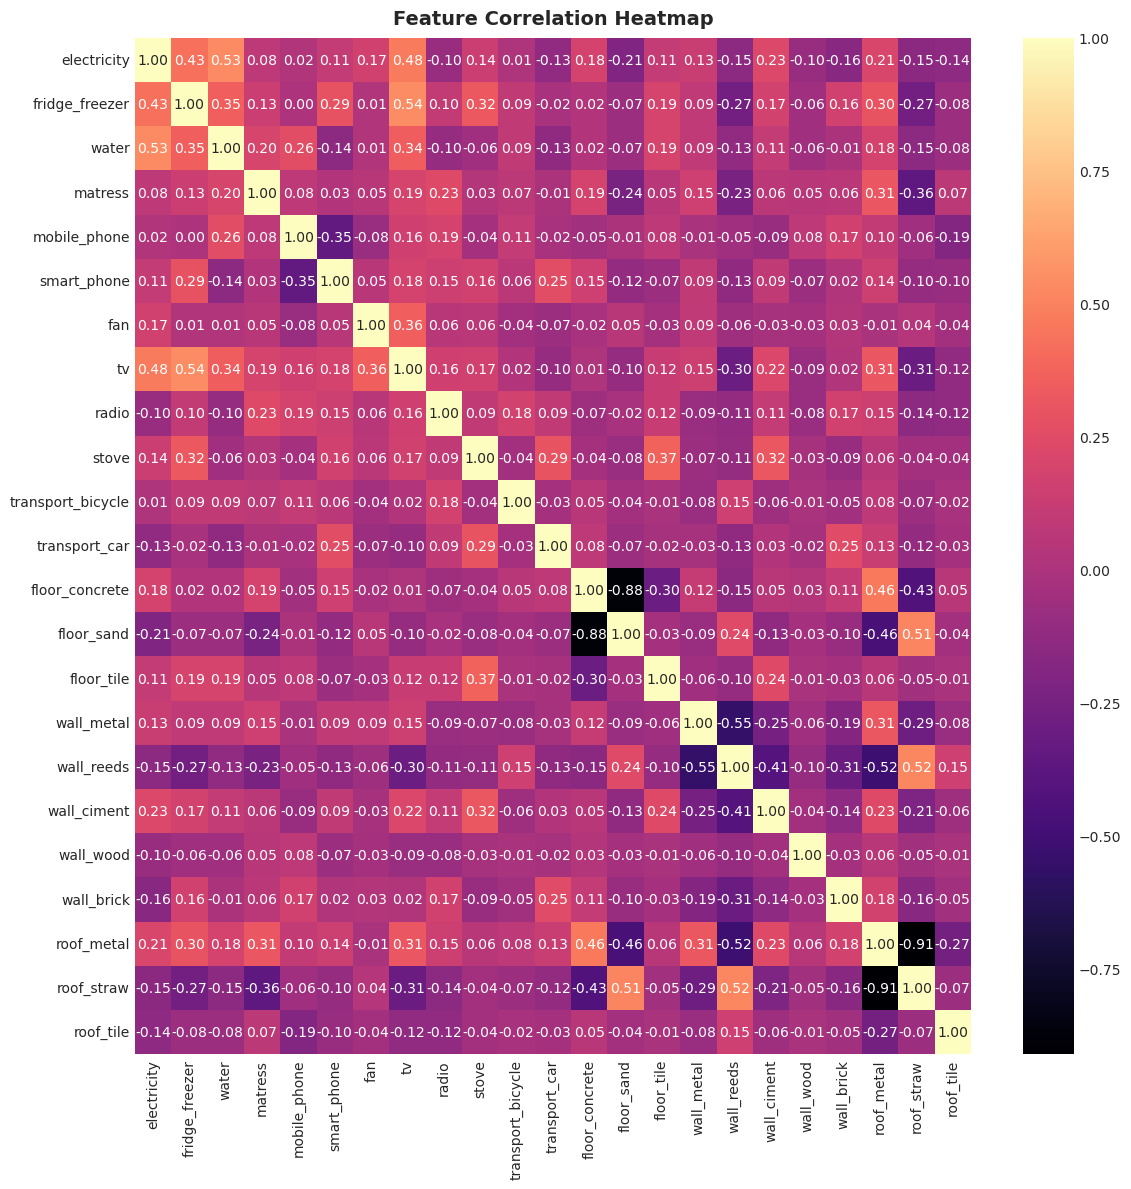

In [606]:
# create covariance matrix
corr_matrix = np.corrcoef(X_norm.T)

# create heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, cmap='magma', annot=True, fmt='.2f',
            xticklabels=df_transformed[num_cols].columns, yticklabels=df_transformed[num_cols].columns)

# set plot title
plt.title('Feature Correlation Heatmap')

# show plot
plt.show()

There are correlations so PCA might be effective in dimensionality reduction.

In [607]:
# calculate eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)

# sort the eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]

# convert to dataframes
eigenvalues_df = pd.DataFrame({'Eigenvalue': eigenvalues}, index=[f"C{i+1}" for i in range(23)])
eigenvalues_df['Proportion'] = eigenvalues_df['Eigenvalue'] / eigenvalues_df['Eigenvalue'].sum()
eigenvalues_df['Cumulative Proportion'] = eigenvalues_df['Proportion'].cumsum()

# display dataframes
print("Eigenvalues:")
display(eigenvalues_df.style.format({'Eigenvalue': '{:.4f}', 'Proportion': '{:.4f}', 'Cumulative Proportion': '{:.4f}'}))

Eigenvalues:


,Eigenvalue,Proportion,Cumulative Proportion
C1,4.1942,0.1824,0.1824
C2,2.3361,0.1016,0.2839
C3,1.8682,0.0812,0.3652
C4,1.7012,0.0740,0.4391
C5,1.5121,0.0657,0.5049
C6,1.3960,0.0607,0.5656
C7,1.1802,0.0513,0.6169
C8,1.1182,0.0486,0.6655
C9,1.0603,0.0461,0.7116
C10,0.9728,0.0423,0.7539


### Scree Test

The first 9 factors have eigenvalues > 1.0. They account for 71% of the variability 

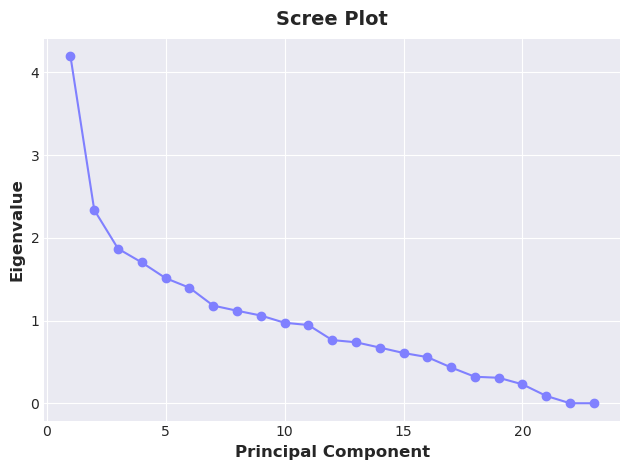

In [608]:
# plot scree plot
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', color='#8080ff')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.show()

The Scree plot suggests 3 components should be rotated

[1.82356141e-01 1.01570801e-01 8.12261972e-02 7.39653893e-02
 6.57419256e-02 6.06977953e-02 5.13110936e-02 4.86167875e-02
 4.61006126e-02 4.22956008e-02 4.11046946e-02 3.32011899e-02
 3.20394724e-02 2.92603453e-02 2.63987812e-02 2.42396289e-02
 1.88037105e-02 1.39129205e-02 1.33844788e-02 9.93439351e-03
 3.83804012e-03 3.80989392e-33 1.23087437e-33]


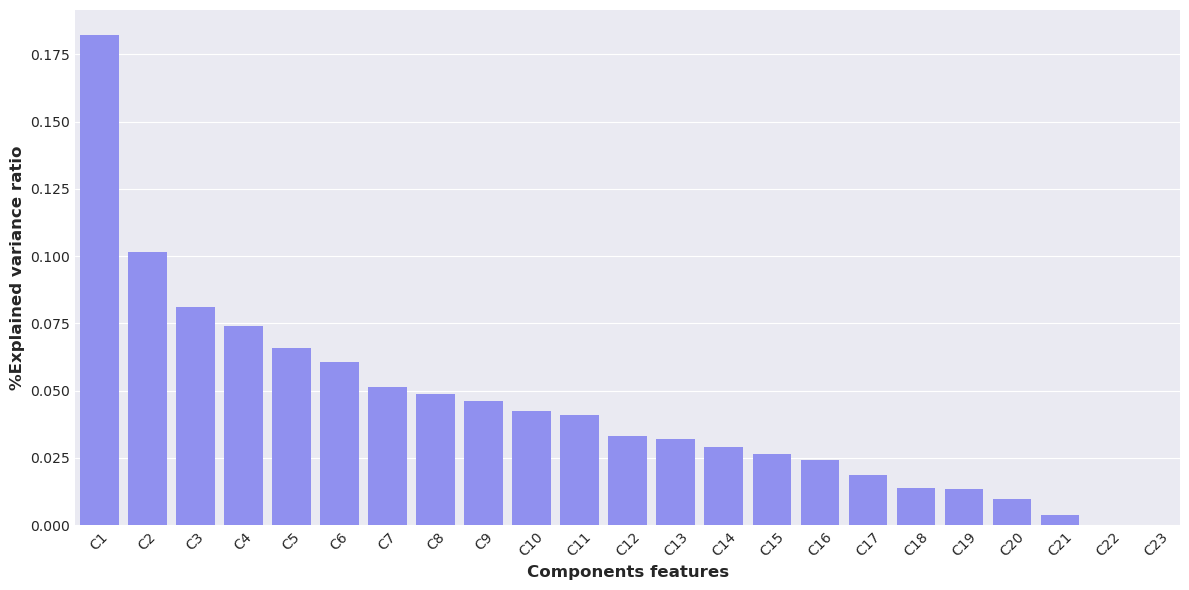

In [609]:
evr = pca.explained_variance_ratio_
print(evr)

# plot the EVR using matplotlib pyplot    
plt.figure(figsize=(12,6))
sns.barplot(x=[f"C{i+1}" for i in range(23)], y=evr, color='#8080ff')
plt.xlabel("Components features")
plt.ylabel("%Explained variance ratio")
plt.xticks(rotation = 45)
plt.show()

[ 4.23834062  6.59905988  8.48692771 10.20603907 11.73401983 13.14476438
 14.33734221 15.46729871 16.538774   17.5218128  18.47717244 19.24883799
 19.99350278 20.67357481 21.28713806 21.85051807 22.28755588 22.61092145
 22.92200491 23.15290113 23.24210526 23.24210526 23.24210526]


<function matplotlib.pyplot.show(close=None, block=None)>

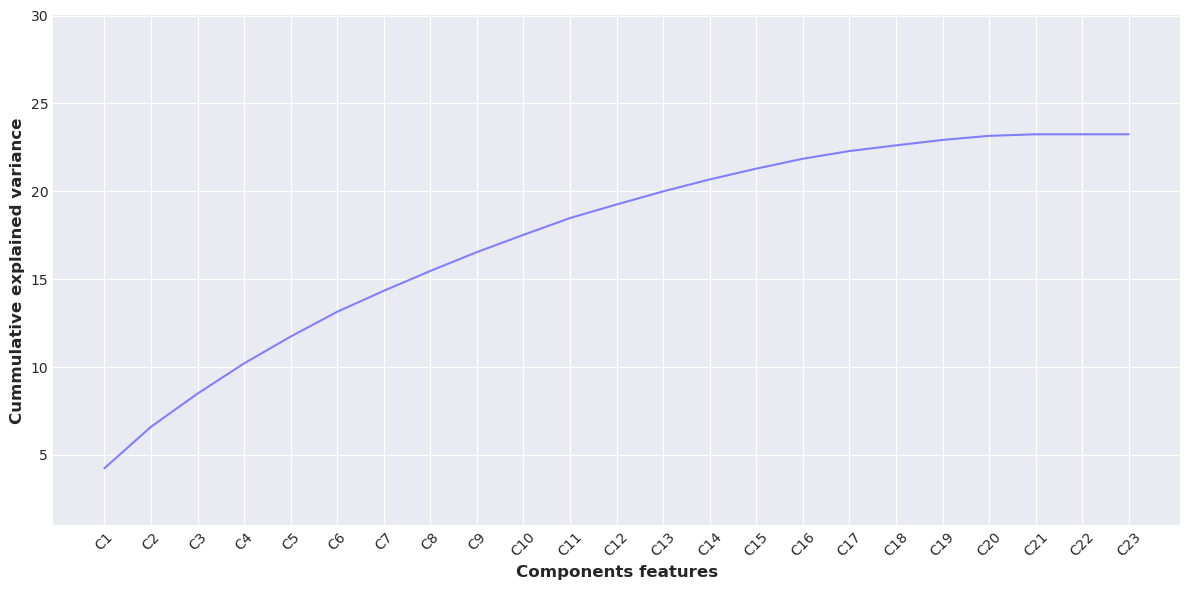

In [610]:
evc = np.cumsum(pca.explained_variance_)
print(evc)

plt.figure(figsize=(12,6))
sns.lineplot(x=[f"C{i+1}" for i in range(23)], y=evc, color='#8080ff')
plt.xlabel("Components features")
plt.ylabel("Cummulative explained variance")
plt.ylim(1,30)
plt.xticks(rotation = 45)
plt.show

### Axis rotation: Varimax

In [611]:
loadings = pd.DataFrame(pca.components_.T[:,:3], index=np.array(features), columns=names[:3])
loadings


,PC1,PC2,PC3
electricity,-0.239142,0.293821,-0.228201
fridge_freezer,-0.272538,0.297530,0.067929
water,-0.185619,0.278592,-0.370573
matress,-0.214982,-0.065356,-0.078610
mobile_phone,-0.053874,0.079133,-0.233263
smart_phone,-0.131058,-0.015754,0.357564
fan,-0.051810,0.152796,-0.048020
tv,-0.286785,0.323305,-0.086236
radio,-0.101053,0.052628,0.249295
stove,-0.117289,0.228297,0.419570


In [612]:
# fit factor analyzer with principal components and varimax rotation
fa = FactorAnalyzer(rotation="varimax", n_factors=3, method='principal')

X = df_transformed[features]

# normalizing features
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)
fa.fit(X_norm)

# get the rotated factor pattern
loadings2 = pd.DataFrame(fa.loadings_, index=X_norm.columns, columns=[f"Factor{i+1}" for i in range(3)])
#rotated_factor_pattern = loadings2[abs(loadings2) >= 0.4].dropna(how='all')

# display the results
loadings2

,Factor1,Factor2,Factor3
electricity,0.233043,0.553466,-0.421935
fridge_freezer,0.233875,0.686205,-0.033783
water,0.177586,0.432706,-0.602613
matress,0.439876,0.124155,-0.079000
mobile_phone,0.076401,0.083733,-0.340444
smart_phone,0.175000,0.232026,0.476187
fan,-0.018580,0.232297,-0.125440
tv,0.267364,0.685642,-0.247708
radio,0.089157,0.252974,0.306200
stove,-0.048675,0.542829,0.458887


In [613]:
rotated_factor_pattern = loadings2[abs(loadings2) >= 0.395].dropna(how='all')
rotated_factor_pattern

,Factor1,Factor2,Factor3
electricity,NaN,0.553466,-0.421935
fridge_freezer,NaN,0.686205,NaN
water,NaN,0.432706,-0.602613
matress,0.439876,NaN,NaN
smart_phone,NaN,NaN,0.476187
tv,NaN,0.685642,NaN
stove,NaN,0.542829,0.458887
transport_car,NaN,NaN,0.627515
floor_concrete,0.764869,NaN,NaN
floor_sand,-0.763026,NaN,NaN


Remove all items with low component loadings (<0.40)

In [614]:
to_remove = loadings2[(abs(loadings2['Factor1'])<0.395) & 
                        (abs(loadings2['Factor2'])<0.395) & 
                        (abs(loadings2['Factor3'])<0.395)]
to_remove_list=to_remove.index.tolist()
to_remove_list

['mobile_phone',
 'fan',
 'radio',
 'transport_bicycle',
 'wall_wood',
 'wall_brick',
 'roof_tile']

## Second PCA Analysis
### Standardize data 

In [615]:
# define features for factor analysis - remove the components with loadings <0.04 (see above)
features = list(df_transformed.columns)
col_remove = ['pract_cat', 'mobile_phone','fan','radio','transport_bicycle','wall_wood','wall_brick','roof_tile']
features = [value for value in features if value not in col_remove]
print(features) 

# normalizing features
X = df_transformed.loc[:, features].values
X_norm = StandardScaler().fit_transform(X) # normalizing the features

# principal component analysis on features
pca = PCA()

X_pca = pca.fit_transform(X_norm)

# converting to dataframe
names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pcadf = pd.DataFrame(X_pca, columns=names)


print(X_pcadf.head())
print("-----------------------------------")
print("Shape of PCA DataFrame:", X_pcadf.shape)

['electricity', 'fridge_freezer', 'water', 'matress', 'smart_phone', 'tv', 'stove', 'transport_car', 'floor_concrete', 'floor_sand', 'floor_tile', 'wall_metal', 'wall_reeds', 'wall_ciment', 'roof_metal', 'roof_straw']
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.467263 -0.558169 -1.176062  1.096641  0.034468  0.094081  0.739124   
1  2.660802 -0.521823 -0.053607 -1.066769  0.119751 -0.717603 -0.025079   
2  2.709468  0.213301 -0.236216 -1.745489 -0.891274  0.579433  2.031242   
3  2.921532 -0.355713  0.922087 -1.032626 -1.681793  0.631279  1.071430   
4 -0.374404 -0.231846 -0.760949 -1.045815  0.017494 -0.288881 -0.594897   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.417048 -0.440631 -0.765710 -1.351874 -0.283491 -0.549809 -0.085871   
1 -0.621999 -1.255698 -0.223569  0.225400  0.939815 -0.258935 -0.408184   
2 -0.073691 -0.258270 -0.131891 -0.184214  0.159647 -0.825734  0.038995   
3 -0.828095 -0.130412  1.111502

### Covariance matrix

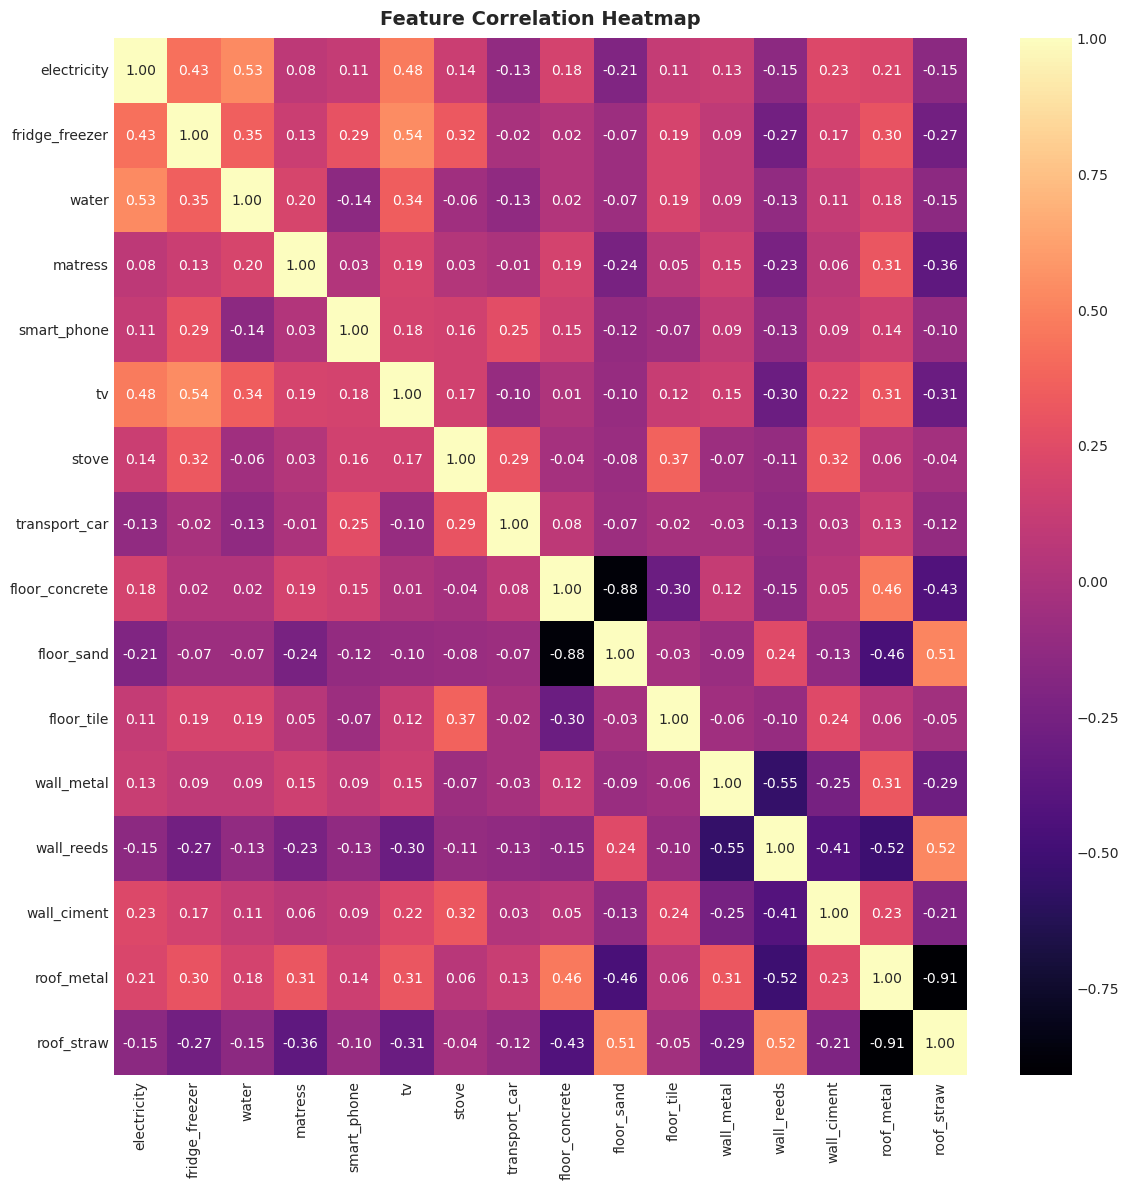

In [616]:
# create covariance matrix
corr_matrix = np.corrcoef(X_norm.T)

# create heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, cmap='magma', annot=True, fmt='.2f',
            xticklabels=df_transformed[features].columns, yticklabels=df_transformed[features].columns)

# set plot title
plt.title('Feature Correlation Heatmap')

# show plot
plt.show()

### Scree Test

In [617]:
# calculate eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)

# sort the eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]

# convert to dataframes
eigenvalues_df = pd.DataFrame({'Eigenvalue': eigenvalues}, index=[f"C{i+1}" for i in range(16)])
eigenvalues_df['Proportion'] = eigenvalues_df['Eigenvalue'] / eigenvalues_df['Eigenvalue'].sum()
eigenvalues_df['Cumulative Proportion'] = eigenvalues_df['Proportion'].cumsum()

# display dataframes
print("Eigenvalues:")
display(eigenvalues_df.style.format({'Eigenvalue': '{:.4f}', 'Proportion': '{:.4f}', 'Cumulative Proportion': '{:.4f}'}))

Eigenvalues:


,Eigenvalue,Proportion,Cumulative Proportion
C1,4.1035,0.2565,0.2565
C2,2.2274,0.1392,0.3957
C3,1.6973,0.1061,0.5018
C4,1.4060,0.0879,0.5896
C5,1.2625,0.0789,0.6685
C6,0.9271,0.0579,0.7265
C7,0.8551,0.0534,0.7799
C8,0.7780,0.0486,0.8286
C9,0.7173,0.0448,0.8734
C10,0.5992,0.0374,0.9108


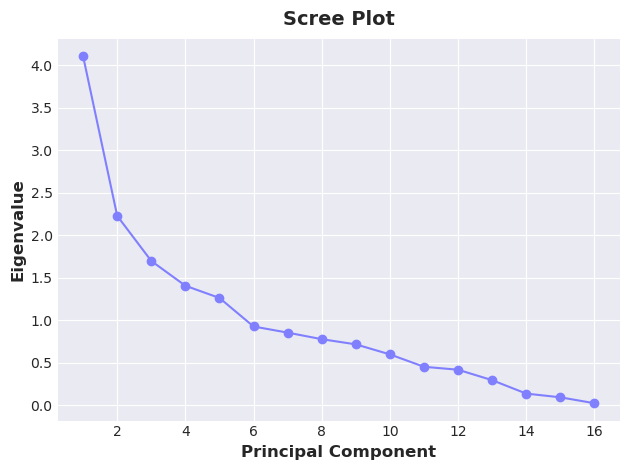

In [618]:
# plot scree plot
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', color='#8080ff')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.show()

The scree test suggests 3 components

[0.25646584 0.13921056 0.10608318 0.08787771 0.0789062  0.05794226
 0.05344323 0.04862453 0.04482873 0.03744979 0.02834905 0.02618083
 0.01849824 0.00865033 0.00591836 0.00157115]


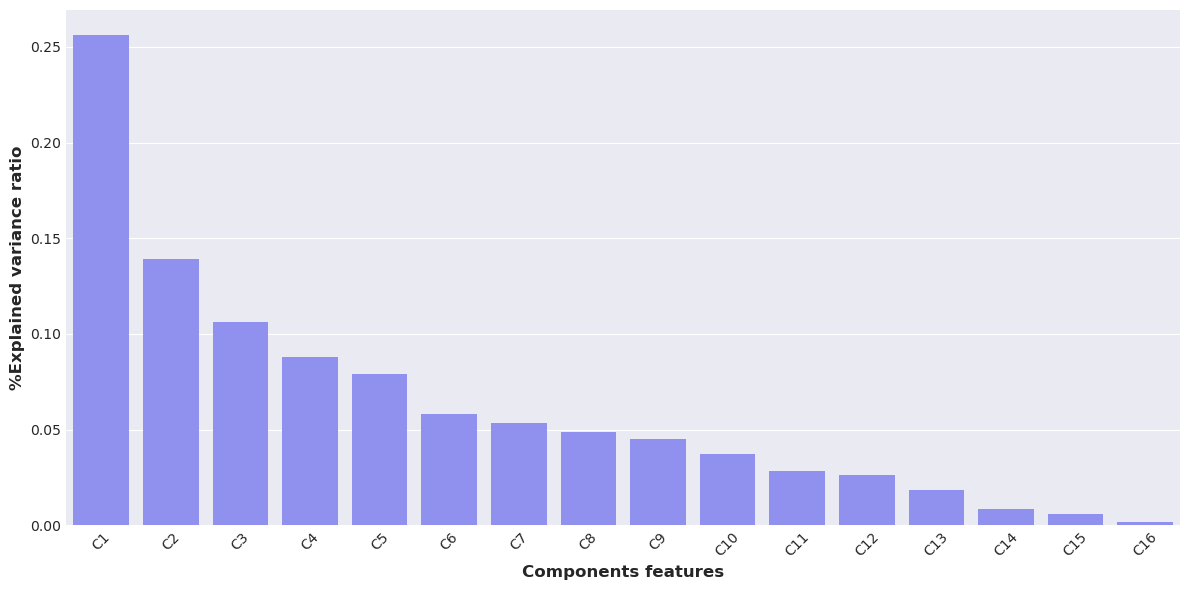

In [619]:
evr = pca.explained_variance_ratio_
print(evr)

# plot the EVR using matplotlib pyplot    
plt.figure(figsize=(12,6))
sns.barplot(x=[f"C{i+1}" for i in range(16)], y=evr, color='#8080ff')
plt.xlabel("Components features")
plt.ylabel("%Explained variance ratio")
plt.xticks(rotation = 45)
plt.show()

### Varimax rotation

In [620]:
# fit factor analyzer with principal components and varimax rotation
fa = FactorAnalyzer(rotation="varimax", n_factors=3, method='principal')

X = df_transformed[features]

# normalizing features
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)
fa.fit(X_norm)

# get the rotated factor pattern
loadings2 = pd.DataFrame(fa.loadings_, index=X_norm.columns, columns=[f"Factor{i+1}" for i in range(3)])


# display the results
loadings2

,Factor1,Factor2,Factor3
electricity,0.171871,0.704673,0.016041
fridge_freezer,0.131977,0.658776,0.334308
water,0.088615,0.728879,-0.206792
matress,0.416239,0.215572,-0.025393
smart_phone,0.187711,-0.043009,0.453120
tv,0.191803,0.711073,0.158525
stove,-0.093604,0.139545,0.777510
transport_car,0.134399,-0.344265,0.561183
floor_concrete,0.800044,-0.194346,-0.032798
floor_sand,-0.771717,0.068104,-0.109665


### Factor analysis

In [621]:
rotated_factor_pattern = loadings2[abs(loadings2) > 0.395].dropna(how='all')
rotated_factor_pattern

,Factor1,Factor2,Factor3
electricity,NaN,0.704673,NaN
fridge_freezer,NaN,0.658776,NaN
water,NaN,0.728879,NaN
matress,0.416239,NaN,NaN
smart_phone,NaN,NaN,0.453120
tv,NaN,0.711073,NaN
stove,NaN,NaN,0.777510
transport_car,NaN,NaN,0.561183
floor_concrete,0.800044,NaN,NaN
floor_sand,-0.771717,NaN,NaN


In [622]:
to_remove = loadings2[(abs(loadings2['Factor1'])<0.395) & 
                        (abs(loadings2['Factor2'])<0.395) & 
                        (abs(loadings2['Factor3'])<0.395)]
to_remove_list=to_remove.index.tolist()
to_remove_list

[]

## Extract Factor Scores
The factor scores are the sum of the component coefficients (component scores) times the sample standardized variables. These coefficients are proportional to the component loadings

In [623]:
# Normalized variables
X = df_transformed.reset_index().set_index(["id","pract_cat"])
X_norm_vals = StandardScaler().fit_transform(X.values)
X_norm = pd.DataFrame(X_norm_vals, index=X.index, columns=X.columns)
X_norm

,,electricity,fridge_freezer,water,matress,mobile_phone,smart_phone,fan,tv,radio,stove,...,floor_sand,floor_tile,wall_metal,wall_reeds,wall_ciment,wall_wood,wall_brick,roof_metal,roof_straw,roof_tile
id,pract_cat,,,,,,,,,,,,,,,,,,,,,
05032023JOSC01,glean,1.064581,-0.545250,-0.54525,0.480384,0.757476,-0.657903,-0.301511,1.183216,1.208941,-0.280449,...,-0.301511,-0.102598,1.732051,-0.959166,-0.430331,-0.102598,-0.321634,0.545250,-0.496743,-0.145865
05032023JOSC02,glean,-0.939336,-0.545250,-0.54525,0.480384,0.757476,-0.657903,-0.301511,-0.845154,-0.827170,-0.280449,...,-0.301511,-0.102598,-0.577350,1.042572,-0.430331,-0.102598,-0.321634,-1.834022,2.013115,-0.145865
05032023JOSC03,fish,1.064581,-0.545250,-0.54525,-2.081666,0.757476,-0.657903,-0.301511,-0.845154,-0.827170,-0.280449,...,-0.301511,-0.102598,-0.577350,1.042572,-0.430331,-0.102598,-0.321634,-1.834022,2.013115,-0.145865
05032023JOSC04,glean,-0.939336,-0.545250,-0.54525,-2.081666,-1.320173,1.519982,-0.301511,-0.845154,-0.827170,-0.280449,...,-0.301511,-0.102598,-0.577350,1.042572,-0.430331,-0.102598,-0.321634,-1.834022,2.013115,-0.145865
05032023JOSC05,shrimp_net,1.064581,-0.545250,-0.54525,0.480384,-1.320173,-0.657903,3.316625,1.183216,-0.827170,-0.280449,...,-0.301511,-0.102598,-0.577350,1.042572,-0.430331,-0.102598,-0.321634,0.545250,-0.496743,-0.145865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19022023ILHC03,shrimp_net,1.064581,-0.545250,-0.54525,-2.081666,-1.320173,-0.657903,-0.301511,-0.845154,-0.827170,-0.280449,...,-0.301511,-0.102598,1.732051,-0.959166,-0.430331,-0.102598,-0.321634,0.545250,-0.496743,-0.145865
19022023ILHC04,shrimp_net,1.064581,-0.545250,-0.54525,0.480384,0.757476,-0.657903,-0.301511,-0.845154,1.208941,-0.280449,...,-0.301511,-0.102598,1.732051,-0.959166,-0.430331,-0.102598,-0.321634,0.545250,-0.496743,-0.145865
19022023ILHc06,shrimp_net,1.064581,-0.545250,-0.54525,0.480384,-1.320173,-0.657903,-0.301511,-0.845154,-0.827170,-0.280449,...,-0.301511,-0.102598,-0.577350,-0.959166,2.323790,-0.102598,-0.321634,0.545250,-0.496743,-0.145865


In [624]:
# function to calculate factor score
def calculate_fact_score(factor, row):
    fact_score = 0
    for componenet in features:
        comp_score = loadings2[factor][componenet]*row[componenet]
        fact_score = fact_score + comp_score
    return fact_score

# calculate factor scores for each factor
for factor in loadings2.columns:
    col = factor + "_score"
    X_norm[col]= X_norm.apply(lambda row: calculate_fact_score(factor, row), axis=1 )

df = X_norm[['Factor1_score', 'Factor2_score', 'Factor3_score']]
df

,,Factor1_score,Factor2_score,Factor3_score
id,pract_cat,,,
05032023JOSC01,glean,2.972634,1.595791,-0.701868
05032023JOSC02,glean,-3.815723,-3.335092,-1.995172
05032023JOSC03,fish,-4.537734,-2.475292,-1.897970
05032023JOSC04,glean,-4.473335,-3.981067,-0.943271
05032023JOSC05,shrimp_net,0.880468,0.571032,-0.759257
...,...,...,...,...
19022023ILHC03,shrimp_net,1.517161,-0.398836,-0.958358
19022023ILHC04,shrimp_net,2.583587,0.153471,-1.023416
19022023ILHc06,shrimp_net,1.807519,0.485148,1.007373


In [625]:
# Normalize factor scores
fact_norm_vals = StandardScaler().fit_transform(df.values)
fact_norm = pd.DataFrame(fact_norm_vals, index=df.index, columns=df.columns)

### Calculate final MSL scores

The final MSL score will be a sum of factor scores scaled by the proportion of variance explained by the factor

In [626]:
#Proportion of variance
print(evr)

[0.25646584 0.13921056 0.10608318 0.08787771 0.0789062  0.05794226
 0.05344323 0.04862453 0.04482873 0.03744979 0.02834905 0.02618083
 0.01849824 0.00865033 0.00591836 0.00157115]


In [627]:
def msl_score(factor1,factor2,factor3):
    score = factor1*evr[0]+ factor2*evr[1]+factor3*evr[2]
    return score

fact_norm["msl"]= fact_norm.apply(lambda row: msl_score(row['Factor1_score'], row['Factor2_score'], row['Factor3_score']), axis=1 )

In [628]:
#Export CSV
fact_norm.to_csv("../msl_scores.csv")

In [629]:
# group by practice category
fact_norm.groupby('pract_cat').describe()


Factor1_score                                                    \
                   count      mean       std       min       25%       50%   
pract_cat                                                                    
fish                48.0  0.094900  0.870578 -2.804484 -0.075311  0.413724   
glean               24.0 -0.081753  0.965679 -2.914646 -0.606987  0.120239   
shrimp_net          24.0 -0.108047  1.286337 -2.914646 -0.033866  0.388235   

                               Factor2_score            ... Factor3_score  \
                 75%       max         count      mean  ...           75%   
pract_cat                                               ...                 
fish        0.634041  1.106102          48.0  0.111995  ...      0.541313   
glean       0.661582  0.944459          24.0 -0.161506  ...     -0.332538   
shrimp_net  0.703198  1.046401          24.0 -0.062484  ...      0.134346   

                       msl                                                    \
                 max count      mean       std       min       25%       50%   
pract_cat                                                                      
fish        4.158064  48.0  0.073952  0.385706 -0.907499 -0.103466  0.095334   
glean       1.928707  24.0 -0.079183  0.405200 -1.009286 -0.354021 -0.072166   
shrimp_net  1.097185  24.0 -0.068720  0.457853 -1.009286 -0.184867  0.048198   

                                
                 75%       max  
pract_cat                       
fish        0.340086  0.773739  
glean       0.202742  0.627117  
shrimp_net  0.209227  0.478805  

[3 rows x 32 columns]